<a href="https://colab.research.google.com/github/seungmindavid/Representational-Learning/blob/main/GAN/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pathlib
import torchvision

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt



# Wasserstein Generative Adversarial Networks (WGANs)

- JS Divergence has gradient issues which lead to unstable training. WGAN bases its loss from Wasserstein Distance.

$\text{max}_{||f|| \leq 1}\mathbb{E}_{x \sim \mathbb{P}_r}[f(x)] - \mathbb{E}_{x \sim \mathbb{P}_θ}[f(x)]$

Critic: maximize separation

Generator: minimize separation.

- After every gradient update on the critic function, clamp the weights to a small fixed range, [-c,c] to remain 1 Lipschitz Continuous.
- Use a new loss function derived from Wasswersetein distance. The critic model does not play as a direct critic but a helper for estimating the Wasswersetein metric between real and genenearted data distribution.
- Empirically, the authors recommended RMSProp optimizer on the critic rather than Adam which could cause instability in the model training.


# Loading Dataset (MNIST)
Batch size
- Train dataset: 128 batch size
- Test dataset: 10 batch

## Details of adversarial training
- batch size: 128
- All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02
- In the LeakyReLU, the slope of the leak was set to 0.2 in all models


In [ ]:
batch_size_train = 128
batch_size_test = 10
img_size = 32

# mean and standard deviation for mnist dataset: 0.1307, 0.3081
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5]),
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download= True, transform=transform),
    batch_size = batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size = batch_size_test, shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 168832633.15it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 110828631.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 138392559.91it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19579166.26it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Loss Construction
- Discriminator: $\text{min}_G \text{max}_D \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1-D(G(z)))]$, with fixed G (Generator).
- $L_{dis} = BCE(D(x), 1) + BCE(D(G(z)), 0)$


- Generator: $\text{max}_G\mathbb{E}_{z\sim p_{z}(z)}[log(D(G(z)))]$ which is equal to $\text{min}_G\mathbb{E}_{z\sim p_{z}(z)}[1-log(D(G(z)))]$ with fixed D
(Discriminator)
- $L_{gen} = -BCE(D(G(z)), 0) = BCE(D(G(z)), 1)$

- The rationale for transitioning the generator from a minimization objective to a maximization objective lies in the common observation that, initially, the discriminator typically exhibits superior performance over the generator. This phenomenon lead $D(G(z))$ to outproduce 0. Particularly, when $x=0$, $log(x)$ has steeper gradient than $log(1-x)$, which faciliates the more efficient training of the Generator.


# Building Discriminator & Generator


In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim, img_dim):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        nn.ConvTranspose2d(z_dim, 512, kernel_size = 4, stride = 1, padding = 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(128, 1, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    return self.gen(x)


class Critic(nn.Module):
  def __init__(self, img_dim):
    super(Critic, self).__init__()
    self.cri = nn.Sequential(
        nn.Conv2d(1, 128, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.cri(x)


In [ ]:

# Hyperparameters
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


# Training WGAN (without gradient penalty)


In [ ]:
# Save model
saved_params_path = "./saved_params_wgan"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

lr = 3e-4
z_dim = 100
image_dim = 28
channels = 1
num_epochs = 50
critic_iteration = 5
weight_clip = 0.01

Gen_Loss = []
Cri_Loss = []

cri = Critic(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)

# Discriminator & Generator
cri_optim = optim.RMSprop(cri.parameters(), lr=lr)
gen_optim = optim.RMSprop(gen.parameters(), lr=lr)


for epoch in range(num_epochs):
  for i, (data, labels) in enumerate(train_loader, 0):
    real = data.to(device)
    labels = labels.to(device)
    #real = real.view(-1, image_dim).to(device)
    batch_size = real.shape[0]

    # Train Critic
    # Critic loss: D(x) - D(G(z))
    # Objective: Maximize Critic loss: -D(x) + (-D(G(z)))
    for _ in range(critic_iteration):
      noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
      fake = gen(noise)

      D_x = cri(real).view(-1)
      D_G_z = cri(fake).view(-1)

      Critic_loss = -torch.mean(D_x) + torch.mean(D_G_z)
      cri.zero_grad()
      Critic_loss.backward(retain_graph = True)
      cri_optim.step()
      ## Clipping weights of critic
      for p in cri.parameters():
        p.data.clamp_(-weight_clip, weight_clip)

    # Train Generator:
    # Generator loss: D(G(z))
    D_G_z = cri(fake).view(-1)
    Generator_loss = -torch.mean(D_G_z)
    gen.zero_grad()
    Generator_loss.backward()
    gen_optim.step()

  print(f"Epoch [{epoch+1}/{num_epochs}]\
        Critic Loss: {Critic_loss.item():.4f}, loss G: {Generator_loss.item():.4f}")
  Gen_Loss.append(Generator_loss.item())
  Cri_Loss.append(Critic_loss.item())
  torch.save(cri.state_dict(), f'{saved_params_path}/critic_{epoch}.pth')
  torch.save(gen.state_dict(), f'{saved_params_path}/generator_{epoch}.pth')


Epoch [1/50]        Critic Loss: -0.1282, loss G: -0.5199
Epoch [2/50]        Critic Loss: -0.1464, loss G: -0.4744
Epoch [3/50]        Critic Loss: -0.1312, loss G: -0.3607
Epoch [4/50]        Critic Loss: -0.1410, loss G: -0.4369
Epoch [5/50]        Critic Loss: -0.0676, loss G: -0.5229
Epoch [6/50]        Critic Loss: -0.0896, loss G: -0.4823
Epoch [7/50]        Critic Loss: -0.1016, loss G: -0.3947
Epoch [8/50]        Critic Loss: -0.0878, loss G: -0.3830
Epoch [9/50]        Critic Loss: -0.1024, loss G: -0.4111
Epoch [10/50]        Critic Loss: -0.1098, loss G: -0.5230
Epoch [11/50]        Critic Loss: -0.1043, loss G: -0.4909
Epoch [12/50]        Critic Loss: -0.0609, loss G: -0.3895
Epoch [13/50]        Critic Loss: -0.0774, loss G: -0.5408
Epoch [14/50]        Critic Loss: -0.0801, loss G: -0.5147
Epoch [15/50]        Critic Loss: -0.0754, loss G: -0.3854
Epoch [16/50]        Critic Loss: -0.0663, loss G: -0.5560
Epoch [17/50]        Critic Loss: -0.0754, loss G: -0.5093
Epoch 

# Plotting Critic vs Generator

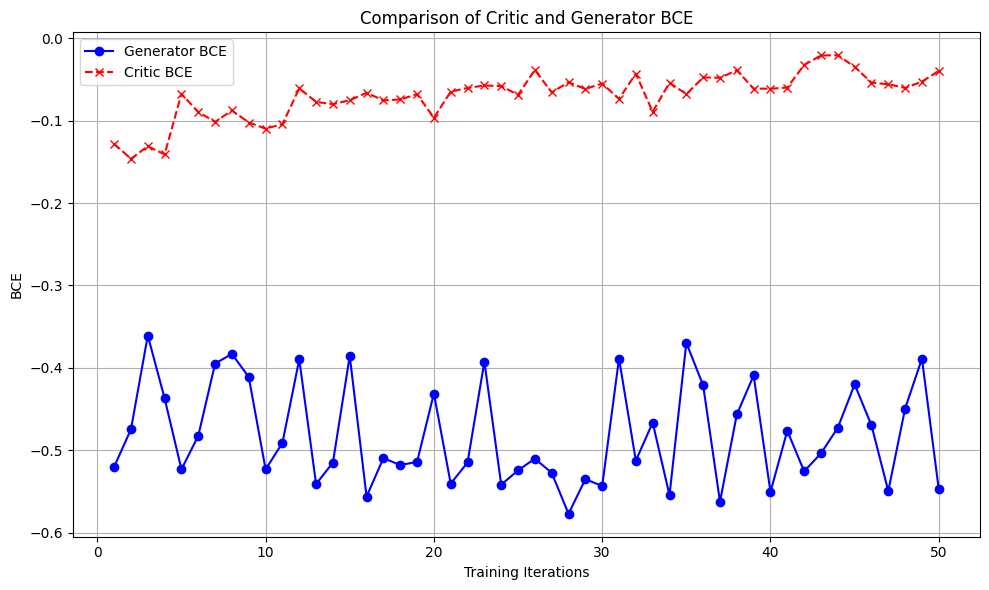

In [ ]:
import matplotlib.pyplot as plt

# Define the x-axis (training iteration or epoch numbers)
iterations = range(1, len(Gen_Loss) + 1)

# Plot the loss curves for both models
plt.figure(figsize=(10, 6))
plt.plot(iterations, Gen_Loss, label='Generator BCE', marker='o', linestyle='-', color='b')
plt.plot(iterations, Cri_Loss, label='Critic BCE', marker='x', linestyle='--', color='r')

# Add labels and a legend
plt.xlabel('Training Iterations')
plt.ylabel('BCE')
plt.title('Comparison of Critic and Generator BCE')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

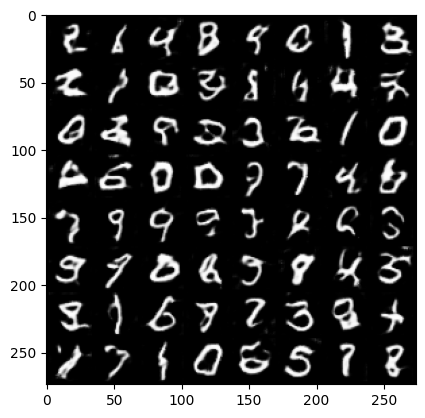

In [ ]:
import numpy as np

with torch.no_grad():
  fake = gen(torch.randn(64, z_dim, 1, 1, device=device))

img_grid = torchvision.utils.make_grid(fake, normalize=True)
plt.imshow(np.transpose(img_grid.cpu().numpy(), (1, 2, 0)), cmap='gray')
plt.show()

### w/ CIFAR-10 Dataset

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 105802555.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([16, 3, 32, 32])
plane plane  ship horse  frog   car   car   dog truck  deer  bird   car   car  frog  bird   dog


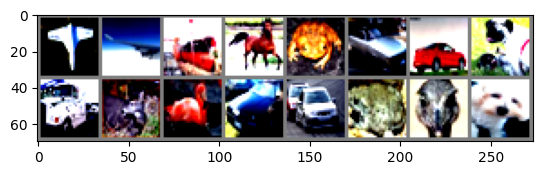

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter =  iter(train_loader)
images, labels = next(dataiter)
print(images.size())

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(images.shape[0])))

In [ ]:

class Generator(nn.Module):
  def __init__(self, z_dim, img_dim):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        nn.ConvTranspose2d(z_dim, 512, kernel_size = 4, stride = 1, padding = 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(128, 3, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    return self.gen(x)


class Critic(nn.Module):
  def __init__(self, img_dim):
    super(Critic, self).__init__()
    self.cri = nn.Sequential(
        nn.Conv2d(3, 128, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.cri(x)


In [ ]:
# Save model
saved_params_path = "./saved_params_wgan_cifar"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

lr = 3e-4
z_dim = 100
image_dim = 28
img_channels = 3
num_epochs = 100
critic_iteration = 5
weight_clip = 0.01
features = 64

Gen_Loss = []
Cri_Loss = []

cri = Critic(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)

# Discriminator & Generator
cri_optim = optim.RMSprop(cri.parameters(), lr=lr)
gen_optim = optim.RMSprop(gen.parameters(), lr=lr)


for epoch in range(num_epochs):
  for i, (real, labels) in enumerate(train_loader, 0):
    real = real.to(device)
    labels = labels.to(device)
    #print(real.shape)
    #real = real.view(-1, image_dim).to(device)
    batch_size = real.shape[0]

    # Train Critic
    # Critic loss: D(x) - D(G(z))
    # Objective: Maximize Critic loss: -D(x) + (-D(G(z)))
    for _ in range(critic_iteration):
      noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
      fake = gen(noise)
      #print(fake.shape)

      D_x = cri(real).view(-1)
      D_G_z = cri(fake).view(-1)

      Critic_loss = -torch.mean(D_x) + torch.mean(D_G_z)
      cri.zero_grad()
      Critic_loss.backward(retain_graph = True)
      cri_optim.step()
      ## Clipping weights of critic
      for p in cri.parameters():
        p.data.clamp_(-weight_clip, weight_clip)

    # Train Generator:
    # Generator loss: D(G(z))
    D_G_z = cri(fake).view(-1)
    Generator_loss = -torch.mean(D_G_z)
    gen.zero_grad()
    Generator_loss.backward()
    gen_optim.step()

  print(f"Epoch [{epoch+1}/{num_epochs}]\
        Critic Loss: {Critic_loss.item():.4f}, loss G: {Generator_loss.item():.4f}")
  Gen_Loss.append(Generator_loss.item())
  Cri_Loss.append(Critic_loss.item())
  torch.save(cri.state_dict(), f'{saved_params_path}/critic_{epoch}.pth')
  torch.save(gen.state_dict(), f'{saved_params_path}/generator_{epoch}.pth')


Epoch [1/100]        Critic Loss: -0.2248, loss G: -0.4060
Epoch [2/100]        Critic Loss: -0.1896, loss G: -0.4372
Epoch [3/100]        Critic Loss: -0.2105, loss G: -0.3633
Epoch [4/100]        Critic Loss: -0.1911, loss G: -0.3603
Epoch [5/100]        Critic Loss: -0.1890, loss G: -0.4272
Epoch [6/100]        Critic Loss: -0.1098, loss G: -0.4628
Epoch [7/100]        Critic Loss: -0.2004, loss G: -0.4550
Epoch [8/100]        Critic Loss: -0.1607, loss G: -0.4409
Epoch [9/100]        Critic Loss: -0.1520, loss G: -0.5096
Epoch [10/100]        Critic Loss: -0.1686, loss G: -0.4392
Epoch [11/100]        Critic Loss: -0.2144, loss G: -0.3776
Epoch [12/100]        Critic Loss: -0.2046, loss G: -0.3935
Epoch [13/100]        Critic Loss: -0.1979, loss G: -0.4132
Epoch [14/100]        Critic Loss: -0.2148, loss G: -0.4056
Epoch [15/100]        Critic Loss: -0.1795, loss G: -0.4013
Epoch [16/100]        Critic Loss: -0.1606, loss G: -0.4517
Epoch [17/100]        Critic Loss: -0.1725, loss 

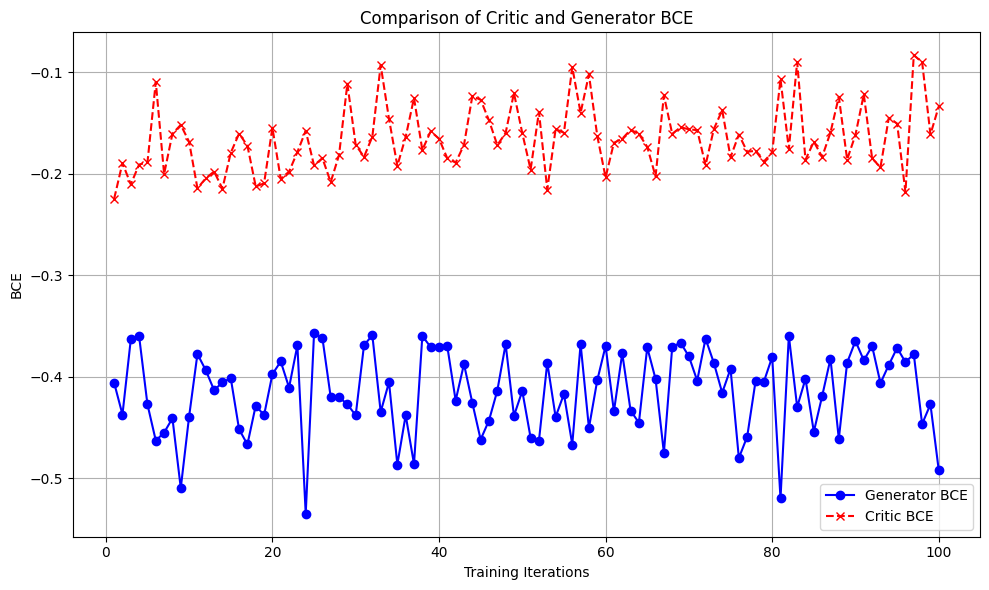

In [ ]:
import matplotlib.pyplot as plt

# Define the x-axis (training iteration or epoch numbers)
iterations = range(1, len(Gen_Loss) + 1)

# Plot the loss curves for both models
plt.figure(figsize=(10, 6))
plt.plot(iterations, Gen_Loss, label='Generator BCE', marker='o', linestyle='-', color='b')
plt.plot(iterations, Cri_Loss, label='Critic BCE', marker='x', linestyle='--', color='r')

# Add labels and a legend
plt.xlabel('Training Iterations')
plt.ylabel('BCE')
plt.title('Comparison of Critic and Generator BCE')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

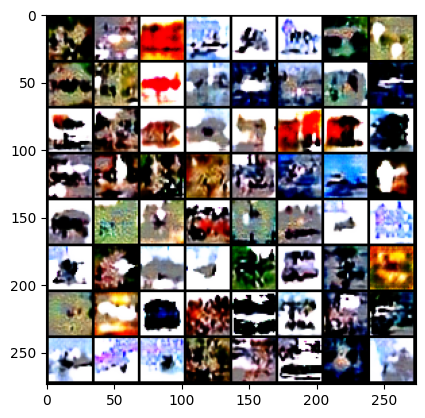

In [ ]:
import numpy as np

lr = 3e-4
z_dim = 100
image_dim = 28
img_channels = 3
num_epochs = 100
critic_iteration = 5
weight_clip = 0.01
features = 64


cri = Critic(image_dim).to(device)
cri.load_state_dict(torch.load('critic_99.pth', map_location=torch.device('cpu')))
cri.eval()

gen = Generator(z_dim, image_dim).to(device)
gen.load_state_dict(torch.load('generator_99.pth', map_location=torch.device('cpu')))
gen.eval()

# Save generated images

with torch.no_grad():
  fake = gen(torch.randn(64, z_dim, 1, 1, device=device))
img_grid = torchvision.utils.make_grid(fake, normalize=True)
plt.imshow(np.transpose(img_grid.cpu().numpy(), (1, 2, 0)), cmap='gray')
plt.show()